# Applied Master Project - Portfolio Insurance: OBPI vs CPPI

### MSc Financial Engineering

Ugo ESCATO  
Aurore CLEVENOT  
Ludovic VINCENTI

# Librairies used

In [137]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

from scipy.stats import norm, skew, kurtosis, jarque_bera
from arch import arch_model
from scipy import stats

# Data

In [138]:
btc_data = yf.download('BTC-USD')
btc_daily = btc_data['Close'][:'2025-02']
btc_weekly = btc_daily.resample('W').last()
btc_monthly = btc_daily.resample('ME').last()

# Extract the date range from the BTC data
start_date = btc_daily.index.min().strftime('%Y-%m-%d')
end_date = btc_daily.index.max().strftime('%Y-%m-%d')

# Download the US T-bill rate for the same period
t_bill_data = yf.download('^IRX', start=start_date, end=end_date)
t_bill_adj_close = t_bill_data['Close']

# Reindex T-bill data to match Bitcoin dates
t_bill_adj_close_reindexed = t_bill_adj_close.reindex(btc_daily.index)

# Interpolate missing T-bill rates
t_bill_daily = t_bill_adj_close_reindexed.interpolate(method='linear')
t_bill_weekly = t_bill_daily.resample('W').last()
t_bill_monthly = t_bill_daily.resample('ME').last()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [139]:
initial_portfolio_value = 100000  
multipliers = [1, 2, 3, 4, 5, 6]  # Array of multipliers
floor_fractions = [0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Array of floor fractions

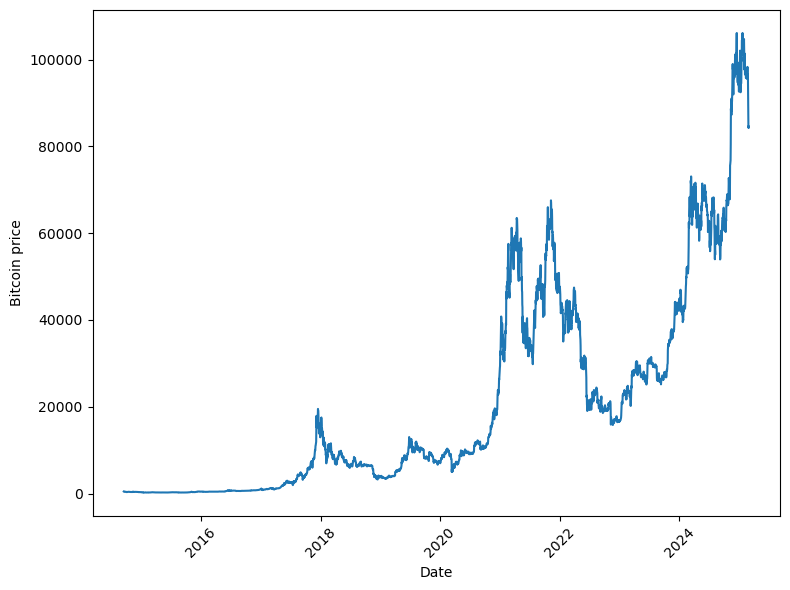

In [140]:
plt.figure(figsize=(8, 6))
plt.plot(btc_daily)
plt.xlabel('Date')
plt.ylabel('Bitcoin price')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

# Calibration

## Normality check

In [141]:
btc_returns = btc_daily.pct_change().dropna()

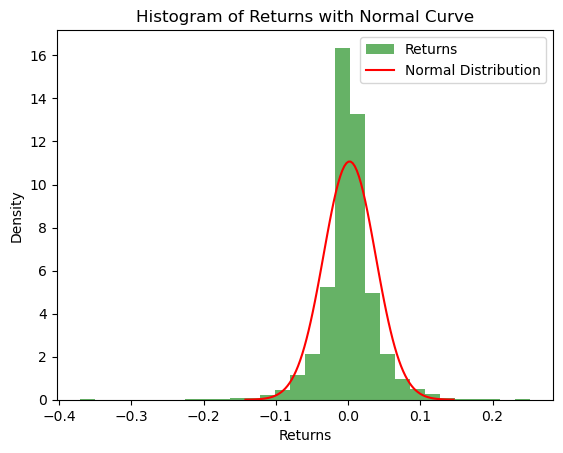

In [142]:
# Plot histogram
plt.hist(btc_returns, bins=30, density=True, alpha=0.6, color='g', label="Returns")

# Overlay normal distribution
mu, std = np.mean(btc_returns), np.std(btc_returns, axis=0)
x = np.linspace(mu - 4*std, mu + 4*std, 100)
plt.plot(x, stats.norm.pdf(x, mu, std), 'r', label="Normal Distribution")

plt.title("Histogram of Returns with Normal Curve")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

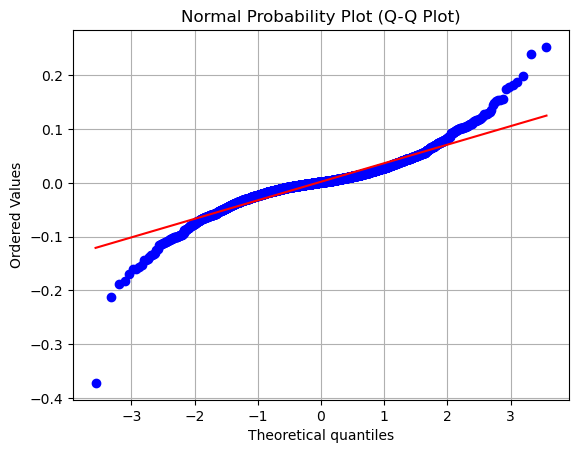

In [143]:
stats.probplot(btc_returns.values.flatten(), dist='norm', plot=plt)
plt.title('Normal Probability Plot (Q-Q Plot)')
plt.grid(True)
plt.show()

In [144]:
# Calculate skewness and kurtosis
skewness = skew(btc_returns)
kurt = kurtosis(btc_returns)
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")

# Interpretation
if abs(skewness) < 0.5 and abs(kurt - 3) < 1:
    print("Returns are approximately normally distributed.")
else:
    print("Returns are NOT normally distributed.")

Skewness: [-0.11085545]
Kurtosis: [7.60254767]
Returns are NOT normally distributed.


In [145]:
# Jarque-Bera test
stat, p = jarque_bera(btc_returns)
print(f"Jarque-Bera Test: Statistic={stat}, p-value={p}")

# Interpretation
alpha = 0.05
if p > alpha:
    print("Fail to reject the null hypothesis: Returns are normally distributed.")
else:
    print("Reject the null hypothesis: Returns are NOT normally distributed.")

Jarque-Bera Test: Statistic=9200.224341408677, p-value=0.0
Reject the null hypothesis: Returns are NOT normally distributed.


As expected, Bitcoin returns do not follow a normal distribution. While the skewness is modest, the returns exhibit heavy tails (high kurtosis), indicating that a normal distribution would underestimate extreme upward and downward movements. For now, we will continue using a GBM for our simulations, incorporating EGARCH to model volatility and capture fat tails. Later, we will address this limitation by adopting more realistic distributions.

## Simulations using GBM

In [146]:
def simulate_gbm(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations):
    """
    Simulates asset price evolution using Geometric Brownian Motion (GBM) with time-varying volatility.

    Parameters:
        initial_price (float): Current asset price.
        mu (float): Drift (mean return).
        sigma (float or np.ndarray): Volatility (constant float or array of shape (total_steps,)).
        time_horizon (float): Time horizon in years.
        steps_per_year (int): Number of time steps per year (e.g., 252 for daily steps).
        num_simulations (int): Number of Monte Carlo simulations.

    Returns:
        np.ndarray: Simulated price paths of shape (steps + 1, simulations).
    """
    # Derived parameters
    dt = 1 / steps_per_year
    total_steps = int(time_horizon * steps_per_year)  # Total number of steps
    
    # Ensure sigma is an array of shape (total_steps,)
    if np.isscalar(sigma):
        sigma = np.full(total_steps, sigma)  # Broadcast to all steps
    elif len(sigma) != total_steps:
        raise ValueError("sigma must be a scalar or an array of length equal to total_steps.")
    
    # Initialize price paths
    price_paths = np.zeros((total_steps + 1, num_simulations))
    price_paths[0] = initial_price  # Set initial price
    
    # Simulate GBM paths with time-varying sigma
    for t in range(1, total_steps + 1):
        z = np.random.standard_normal(num_simulations)  # Random shocks
        
        # GBM formula with time-dependent sigma[t-1] (since sigma is 0-indexed)
        price_paths[t] = price_paths[t - 1] * np.exp(
            (mu - 0.5 * sigma[t - 1]**2) * dt + sigma[t - 1] * np.sqrt(dt) * z
        )
    
    return price_paths

### Historical volatility

In [147]:
def calculate_mean_and_volatility(returns):
    # Compute simple returns for mean
    simple_returns = returns.pct_change().dropna()
    
    # Compute log returns for volatility
    log_returns = np.log(returns / returns.shift(1)).dropna()
    
    # Calculate mean using simple returns
    mean = simple_returns.mean() * 365
    
    # Calculate volatility using log returns
    volatility = log_returns.std() * np.sqrt(365)
    
    return mean, volatility

In [148]:
mean, volatility = calculate_mean_and_volatility(btc_daily)
sharpe_ratio = mean/volatility

print(f"Mean (Simple Returns): {mean}")
print(f"Volatility (Log Returns): {volatility}")
print(f'Sharpe Ratio: {sharpe_ratio}')

Mean (Simple Returns): Ticker
BTC-USD    0.737998
dtype: float64
Volatility (Log Returns): Ticker
BTC-USD    0.693099
dtype: float64
Sharpe Ratio: Ticker
BTC-USD    1.06478
dtype: float64


In [149]:
initial_price = btc_daily.iloc[-1]  # Adjust with daily or weekly
mu = float(mean.iloc[0])  # Drift (annualized mean return) 365 for daily, 52 for weekly
sigma = float(volatility.iloc[0])  # Volatility (annualized standard deviation)
time_horizon = 1  # 1 years
steps_per_year = 365  # 365 for daily, 52 for weekly
num_simulations = 1000  # Number of Monte Carlo simulations

price_paths = simulate_gbm(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations)

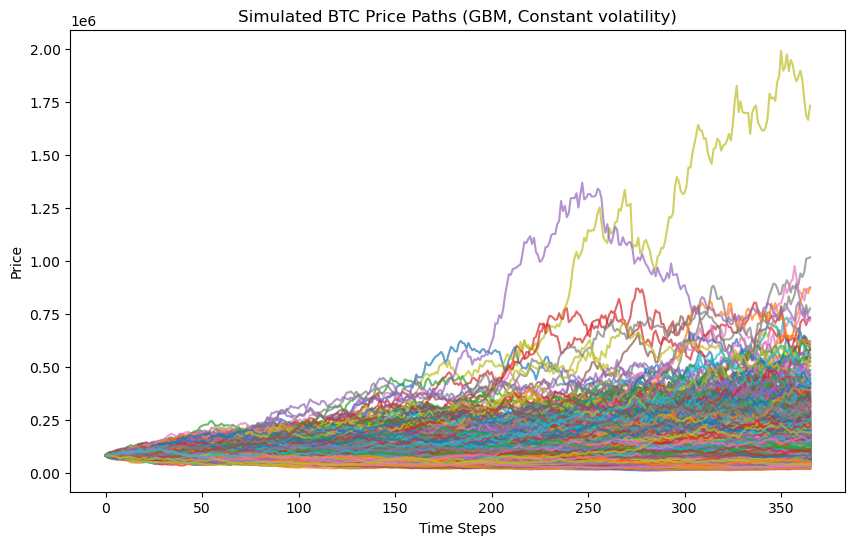

In [150]:
# Plot some simulated paths
plt.figure(figsize=(10, 6))
plt.plot(price_paths, alpha=0.7)
plt.title("Simulated BTC Price Paths (GBM, Constant volatility)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()

#### CPPI

In [151]:
def cppi_strategy(risky_asset, riskless_rate, multipliers, floor_fractions, initial_portfolio_value):
    """
    Implements the CPPI (Constant Proportion Portfolio Insurance) strategy for multiple combinations
    of multiplier and floor_fraction values.

    Parameters:
        risky_asset (ndarray): Prices of the risky asset (e.g., BTC), shape (n_steps, n_simulations).
        riskless_rate (float): The constant annual risk-free rate (e.g., 0.02 for 2%).
        multipliers (array-like): Array of multipliers for the cushion.
        floor_fractions (array-like): Array of floor fractions of the initial portfolio value.
        initial_portfolio_value (float): Initial value of the portfolio.

    Returns:
        dict: A dictionary containing results for each (multiplier, floor_fraction) combination.
    """

    n_steps, n_simulations = risky_asset.shape
    # Calculate daily riskless return from the annual riskless rate
    riskless_return = (1 + riskless_rate) ** (1 / 365) - 1

    results = {}

    for multiplier in multipliers:
        for floor_fraction in floor_fractions:
            # Initialize arrays
            basket_values = np.zeros((n_steps, n_simulations))
            risky_weights = np.zeros((n_steps, n_simulations))
            riskless_weights = np.zeros((n_steps, n_simulations))

            # Initial conditions
            basket_values[0] = initial_portfolio_value
            floor = initial_portfolio_value * floor_fraction

            # Compute the initial cushion
            initial_cushion = np.maximum(basket_values[0] - floor, 0) / basket_values[0]
            risky_weights[0] = np.maximum(multiplier * initial_cushion, 0)
            riskless_weights[0] = 1 - risky_weights[0]

            # CPPI dynamics for each time step
            for t in range(1, n_steps):
                # Compute risky returns
                risky_returns = (risky_asset[t] - risky_asset[t - 1]) / risky_asset[t - 1]

                # Portfolio return: combine risky and riskless returns
                port_returns = (risky_weights[t-1] * risky_returns + 
                               riskless_weights[t-1] * riskless_return)
                
                # Update portfolio value
                basket_values[t] = basket_values[t-1] * (1 + port_returns)
                
                # Update weights
                cushion = np.maximum(basket_values[t] - floor, 0) / basket_values[t]
                risky_weights[t] = np.maximum(multiplier * cushion, 0)
                riskless_weights[t] = 1 - risky_weights[t]

            # Store the results for the current multiplier and floor_fraction
            results[(multiplier, floor_fraction)] = {
                'Basket Values': basket_values,
                'Risky Weights': risky_weights,
                'Riskless Weights': riskless_weights
            }

    return results

In [152]:
# Run CPPI strategy for all combinations
cppi_results = cppi_strategy(price_paths, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [153]:
# Select a (multiplier, floor) combination
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

# Get terminal prices and CPPI values
terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_cppi = cppi_results[key]['Basket Values'][-1]  # Last row of CPPI values

#### OBPI

In [154]:
def obpi_strategy(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity, sigma):
    """
    Implements the OBPI (Option-Based Portfolio Insurance) strategy for multiple floor fractions.

    Parameters:
        risky_asset (ndarray): Simulated risky asset prices, shape (n_steps, n_simulations).
        riskless_rate (float): Annualized risk-free rate (e.g., 0.02 for 2%).
        floor_fractions (list): List of floor fractions to test.
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.
        sigma (float or ndarray): Volatility of the risky asset (annualized), 
                                  either a float (constant) or ndarray (n_steps, n_simulations).

    Returns:
        dict: Dictionary containing results for each floor fraction.
    """
    n_steps, n_simulations = risky_asset.shape
    steps_per_year = 365  # adjust
    riskless_return = (1 + riskless_rate) ** (1 / steps_per_year) - 1
    dt = 1 / steps_per_year  
    results = {}

    def black_scholes_put(S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)
        return put_price, put_delta

    # Ensure sigma is an array of correct shape (n_steps, n_simulations)
    if np.isscalar(sigma):
        sigma = np.full((n_steps, n_simulations), sigma)

    if sigma.shape != (n_steps, n_simulations):
        raise ValueError("sigma must be either a scalar or have shape (n_steps, n_simulations)")

    for floor_fraction in floor_fractions:
        # Initialize arrays
        basket_values = np.zeros((n_steps, n_simulations))
        risky_weights = np.zeros((n_steps, n_simulations))
        riskless_weights = np.zeros((n_steps, n_simulations))
        put_prices = np.zeros((n_steps, n_simulations))
        put_deltas = np.zeros((n_steps, n_simulations))

        # Initial conditions
        floor = initial_portfolio_value * floor_fraction

        # Compute initial put price and delta for all simulations
        initial_put_price, initial_put_delta = black_scholes_put(
            risky_asset[0], floor, time_to_maturity, riskless_rate, sigma[0]
        )

        # Compute initial weights
        risky_w = ((1 + initial_put_delta) * risky_asset[0]) / (risky_asset[0] + initial_put_price)
        risky_w = np.maximum(0, np.minimum(1, risky_w))
        riskless_w = 1 - risky_w

        # Set initial values
        basket_values[0, :] = initial_portfolio_value
        risky_weights[0, :] = risky_w
        riskless_weights[0, :] = riskless_w
        put_prices[0, :] = initial_put_price
        put_deltas[0, :] = initial_put_delta

        # Loop over time steps
        for i in range(1, n_steps):
            remaining_ttm = time_to_maturity - i * dt  # Remaining time to maturity

            # Compute returns
            risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]

            # Update portfolio value
            portfolio_return = (risky_weights[i - 1] * risky_return +
                                riskless_weights[i - 1] * riskless_return)
            basket_values[i] = basket_values[i - 1] * (1 + portfolio_return)

            # Compute new put option price and delta (handle time-varying sigma)
            put_price, put_delta = black_scholes_put(
                risky_asset[i], floor, remaining_ttm, riskless_rate, sigma[i]
            )

            # Update weights
            risky_w = ((1 + put_delta) * risky_asset[i]) / (risky_asset[i] + put_price)
            risky_w = np.maximum(0, np.minimum(1, risky_w))
            riskless_w = 1 - risky_w

            # Store values
            risky_weights[i] = risky_w
            riskless_weights[i] = riskless_w
            put_prices[i] = put_price
            put_deltas[i] = put_delta

        # Store results
        results[floor_fraction] = {
            "Basket Values": basket_values,
            "Risky Weights": risky_weights,
            "Riskless Weights": riskless_weights,
            "Put Price": put_prices,
            "Put Delta": put_deltas,
        }

    return results

In [155]:
time_to_maturity = len(price_paths)/365  # adjust (52 for weekly, 365 for daily)

obpi_results = obpi_strategy(price_paths, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, float(volatility.iloc[0]))

In [156]:
# Select a (multiplier, floor) combination
floor_frac_obpi = 1
key = (floor_frac_obpi)

# Get terminal prices and CPPI values
terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_obpi = obpi_results[key]['Basket Values'][-1]  # Last row of obpi values

#### Buy and Hold

In [157]:
def buy_and_hold_strategy(price_paths, riskless_rate, initial_portfolio_value, time_to_maturity):
    """
    Implements a 60/40 buy-and-hold strategy with a risky asset and a riskless asset.

    Parameters:
        price_paths (ndarray): Simulated risky asset prices, shape (n_steps, n_simulations).
        riskless_rate (float): Annualized risk-free rate (e.g., 0.02 for 2%).
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.

    Returns:
        dict: Dictionary containing portfolio values, risky asset values, and riskless asset values.
    """
    n_steps, n_simulations = price_paths.shape
    dt = time_to_maturity / (n_steps - 1)  # Time step in years

    # Initialize arrays
    portfolio_values = np.zeros((n_steps, n_simulations))
    risky_values = np.zeros((n_steps, n_simulations))
    riskless_values = np.zeros((n_steps, n_simulations))

    # Initial allocation: 60% risky, 40% riskless
    risky_weight = 0.6
    riskless_weight = 0.4

    # Initial values
    risky_values[0, :] = initial_portfolio_value * risky_weight
    riskless_values[0, :] = initial_portfolio_value * riskless_weight
    portfolio_values[0, :] = initial_portfolio_value

    # Compute riskless asset growth over time
    time_steps = np.arange(n_steps) * dt  # Time points in years
    riskless_growth = (1 + riskless_rate) ** time_steps  # Cumulative growth of riskless asset
    riskless_asset_values = initial_portfolio_value * riskless_weight * riskless_growth[:, np.newaxis]

    # Compute risky asset growth based on price_paths
    risky_initial_price = price_paths[0]  # Initial price (array of shape (n_simulations,))
    risky_asset_values = risky_values[0, :] * (price_paths / risky_initial_price)

    # Portfolio value is the sum of risky and riskless components
    portfolio_values = risky_asset_values + riskless_asset_values

    # Store results
    results = {
        "Basket Values": portfolio_values,
        "Risky Values": risky_asset_values,
        "Riskless Values": riskless_asset_values,
    }

    return results

In [158]:
# Run the strategy
bnh_results = buy_and_hold_strategy(
    price_paths=price_paths,
    riskless_rate=0.04,
    initial_portfolio_value=100000,
    time_to_maturity=len(price_paths)/365
)

In [159]:
# Get terminal prices and CPPI values
terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_bnh = bnh_results['Basket Values'][-1]  # Last row of CPPI values

##### Analysis

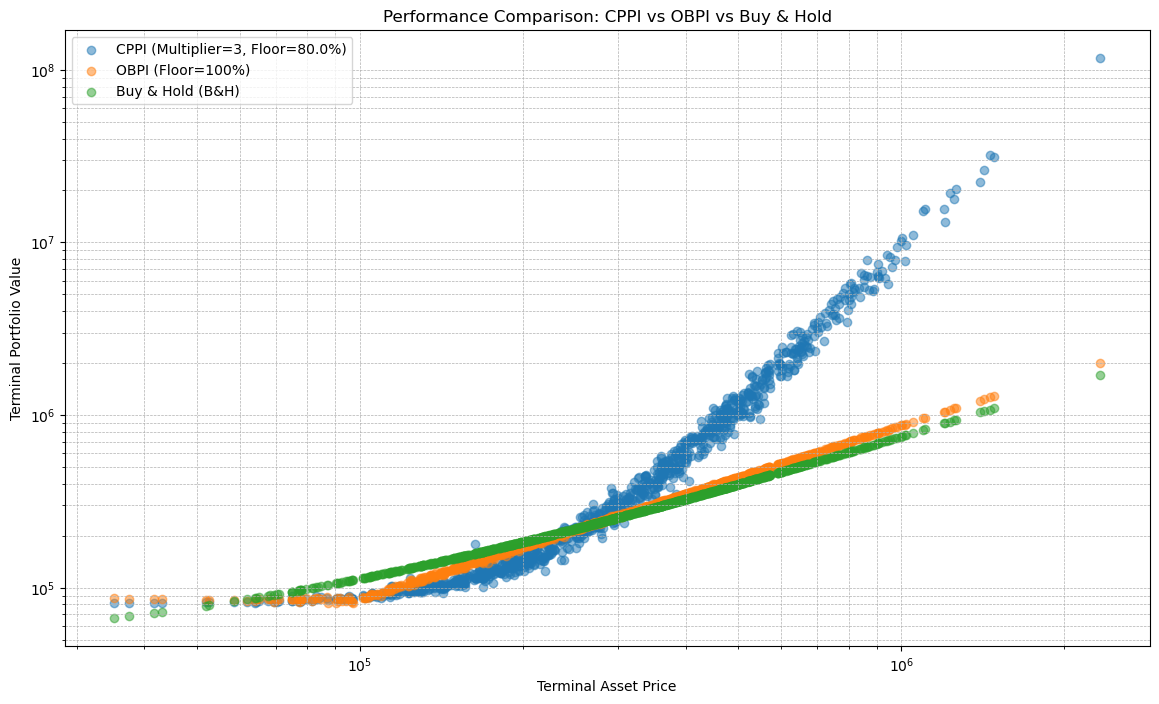

In [220]:
# Create a combined figure for CPPI, OBPI, and Buy & Hold
plt.figure(figsize=(14, 8))

# CPPI Outcomes (with multiplier and floor)
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# OBPI Outcomes (with floor)
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Floor={floor_frac_obpi*100}%)')

# Buy & Hold (B&H) Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='Buy & Hold (B&H)')

# Customize plot aesthetics
plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [316]:
def performance(portfolio_values, benchmark_prices):
    """
    Calculate performance metrics for a portfolio across multiple simulations with benchmark.

    Parameters:
    - portfolio_values (np.ndarray): Shape (n_steps, n_simulations), portfolio values over time.
    - benchmark_prices (np.ndarray): Shape (n_steps, n_simulations), benchmark values over time.

    Returns:
    - dict: Averaged performance metrics across simulations:
        - annualized return, volatility, Sharpe ratio, Sortino ratio,
          VaR 5%, Expected Shortfall (CVaR), skewness, kurtosis, max drawdown,
          and information ratio.
    """
    # Ensure inputs are NumPy arrays
    portfolio_values = np.asarray(portfolio_values)
    benchmark_prices = np.asarray(benchmark_prices)

    # Validate dimensions
    if portfolio_values.shape != benchmark_prices.shape:
        raise ValueError("portfolio_values and benchmark_prices must have the same shape.")
        
    if portfolio_values.shape[0] < 2:
        raise ValueError("At least two time steps are required for performance calculation.")
        
    # Dimensions
    n_steps, n_simulations = portfolio_values.shape

    total_return = (portfolio_values[-1, :] / portfolio_values[0, :]) - 1

    def safe_annualized_return(total_return, n_steps, periods_per_year=365):
        # Check for invalid inputs
        if n_steps <= 0:
            raise ValueError("n_steps must be greater than zero for annualization.")
            
        if np.any(np.isnan(total_return)) or np.any(np.isinf(total_return)):
            raise ValueError("total_return contains NaN or Inf values.")
            
        # Ensure valid range for total_return
        total_return = np.clip(total_return, -0.999, None)  # Avoid (1 + total_return) < 0

        # Calculate annualized return safely
        try:
            annualized_return = (1 + total_return) ** (periods_per_year / n_steps) - 1
        except Exception as e:
            raise RuntimeError(f"Error computing annualized return: {e}")

        return annualized_return
    
    annualized_return = safe_annualized_return(total_return, n_steps)

    # Daily returns (or periodic returns)
    portfolio_daily_returns = np.diff(portfolio_values, axis=0) / portfolio_values[:-1, :]
    benchmark_daily_returns = np.diff(benchmark_prices, axis=0) / benchmark_prices[:-1, :]

    # Annualized volatility
    annualized_volatility = np.std(portfolio_daily_returns, axis=0) * np.sqrt(365)

    # Sharpe ratio (assuming risk-free rate = 0)
    sharpe_ratio = annualized_return / annualized_volatility

    # Sortino ratio (downside risk only)
    downside_returns = np.where(portfolio_daily_returns < 0, portfolio_daily_returns, 0)
    downside_risk = np.std(downside_returns, axis=0) * np.sqrt(365)
    sortino_ratio = annualized_return / downside_risk

    # Value at Risk (VaR 5%) and Conditional VaR (Expected Shortfall)
    var_5 = np.percentile(portfolio_daily_returns, 5, axis=0)
    es_5 = np.array([np.mean(portfolio_daily_returns[:, i][portfolio_daily_returns[:, i] <= var_5[i]]) for i in range(n_simulations)])

    # Skewness and kurtosis (using scipy for better performance)
    skewness = np.mean(((portfolio_daily_returns - np.mean(portfolio_daily_returns, axis=0))**3), axis=0) / np.std(portfolio_daily_returns, axis=0)**3
    kurtosis = np.mean(((portfolio_daily_returns - np.mean(portfolio_daily_returns, axis=0))**4), axis=0) / np.std(portfolio_daily_returns, axis=0)**4

    # Maximum drawdown calculation (in percentage)
    cumulative_max = np.maximum.accumulate(portfolio_values, axis=0)
    drawdown = (portfolio_values - cumulative_max) / cumulative_max
    max_drawdown = np.min(drawdown, axis=0) * 100

    # Information ratio (excess return relative to the benchmark)
    excess_returns = portfolio_daily_returns - benchmark_daily_returns
    information_ratio = np.divide(np.mean(excess_returns, axis=0), np.std(excess_returns, axis=0), where=np.std(excess_returns, axis=0) > 0) * np.sqrt(365)

    # Collect and return the mean of each metric across simulations
    return {
        'annualized_return': np.mean(annualized_return),
        'annualized_volatility': np.mean(annualized_volatility),
        'sharpe_ratio': np.mean(sharpe_ratio),
        'sortino_ratio': np.mean(sortino_ratio),
        'var_5': np.mean(var_5),
        'es_5': np.mean(es_5),
        'skewness': np.mean(skewness),
        'kurtosis': np.mean(kurtosis),
        'max_drawdown': np.mean(max_drawdown),
        'information_ratio': np.mean(information_ratio)
    }


In [281]:
def annualized_turnover(strategy_results, periods_per_year):
        # Extract risky weights (n_steps, n_simulations)
    weights = np.asarray(strategy_results['Risky Weights'])
    
    # Ensure shape consistency
    if len(weights.shape) != 2:
        raise ValueError("Risky Weights must have shape (n_steps, n_simulations)")
    
    # Compute absolute weight changes across time (axis=0: time dimension)
    turnover = np.abs(np.diff(weights, axis=0))  # Shape: (n_steps-1, n_simulations)
    
    # Average turnover per simulation
    mean_turnover_per_sim = np.mean(turnover, axis=0)  # Shape: (n_simulations,)
    
    # Annualize turnover: Multiply by periods_per_year (e.g., 365 for daily rebalancing)
    annualized_turnover_per_sim = mean_turnover_per_sim * periods_per_year
    
    # Return the mean annualized turnover across all simulations
    return np.mean(annualized_turnover_per_sim) * 100  # Return as percentage

In [320]:
benchmark_prices = price_paths

# CPPI Strategy Performance
cppi_strategy_results = cppi_results[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = annualized_turnover(cppi_strategy_results, 365)

# OBPI Strategy Performance
obpi_strategy_results = obpi_results[1]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices)
obpi_turnover = annualized_turnover(obpi_strategy_results, 365)

# Buy-and-Hold Strategy Performance
bnh_portfolio_values = np.array(bnh_results['Basket Values'])
bnh_metrics = performance(bnh_portfolio_values, benchmark_prices)
bnh_turnover = 0  # No turnover for B&H

# Display Results
def print_metrics(name, metrics, turnover):
    print(f"{name} Strategy Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    print(f"Annualized Turnover: {turnover:.2f}%\n")

print_metrics("CPPI", cppi_metrics, cppi_turnover)
print_metrics("OBPI", obpi_metrics, obpi_turnover)
print_metrics("Buy-and-Hold", bnh_metrics, bnh_turnover)

CPPI Strategy Metrics:
Annualized Return: 1.4971
Annualized Volatility: 0.6258
Sharpe Ratio: 0.9989
Sortino Ratio: 1.9056
Var 5: -0.0516
Es 5: -0.0718
Skewness: -0.0952
Kurtosis: 5.7613
Max Drawdown: -42.1268
Information Ratio: -0.6463
Annualized Turnover: 1449.97%

OBPI Strategy Metrics:
Annualized Return: 0.6112
Annualized Volatility: 0.4157
Sharpe Ratio: 0.9645
Sortino Ratio: 1.8709
Var 5: -0.0342
Es 5: -0.0458
Skewness: -0.0152
Kurtosis: 5.0962
Max Drawdown: -30.1918
Information Ratio: -1.2599
Annualized Turnover: 625.56%

Buy-and-Hold Strategy Metrics:
Annualized Return: 0.6609
Annualized Volatility: 0.4500
Sharpe Ratio: 1.2906
Sortino Ratio: 2.4247
Var 5: -0.0366
Es 5: -0.0460
Skewness: 0.0797
Kurtosis: 3.1153
Max Drawdown: -32.4448
Information Ratio: -1.1946
Annualized Turnover: 0.00%



### Simulated Volatility

#### EGARCH, Student distribution

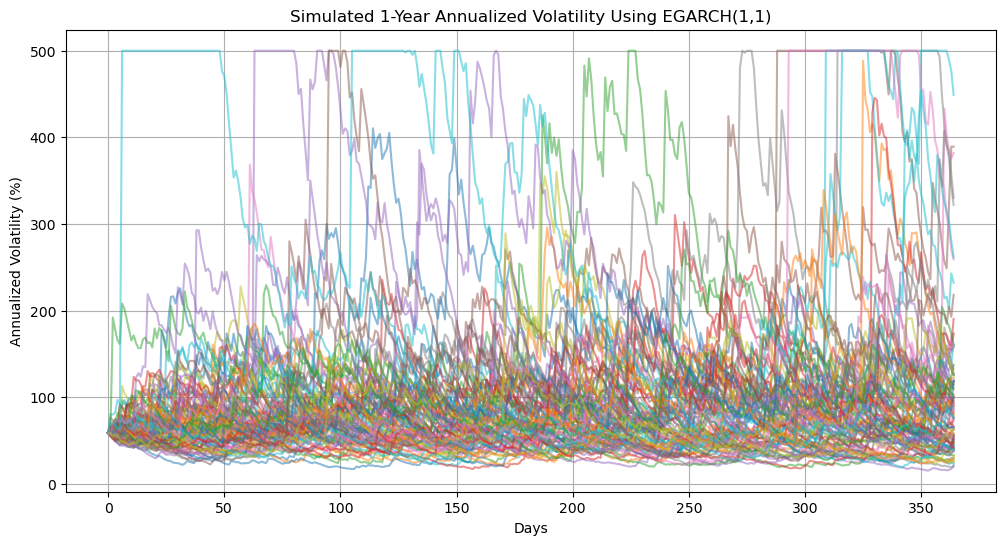

In [164]:
model = arch_model(btc_returns*100, vol='EGARCH', p=1, q=1, dist='t')  # Use Student's t for fat tails
fit = model.fit(disp='off')  # Suppress output

n_days = 365  
n_simulations = 1000
vol_cap = 5

# Forecast future volatility
forecast = fit.forecast(horizon=n_days, simulations=n_simulations, method='simulation')

# Extract simulated daily volatility (square root of variances)
simulated_volatility_daily = np.sqrt(forecast.simulations.variances) / 100

# Convert daily volatility to annualized volatility 
simulated_volatility_annualized = simulated_volatility_daily * np.sqrt(365)
simulated_volatility_annualized = np.minimum(simulated_volatility_annualized, vol_cap)

# Plot the simulated annualized volatility paths
plt.figure(figsize=(12, 6))

# Plot a subset of random paths for better visualization
for i in range(100):  # 100 sample paths
    plt.plot(simulated_volatility_annualized.T[:, i]*100, alpha=0.5)

# Plot the mean annualized volatility path
plt.title("Simulated 1-Year Annualized Volatility Using EGARCH(1,1)")
plt.xlabel("Days")
plt.ylabel("Annualized Volatility (%)")
plt.grid(True)
plt.show()


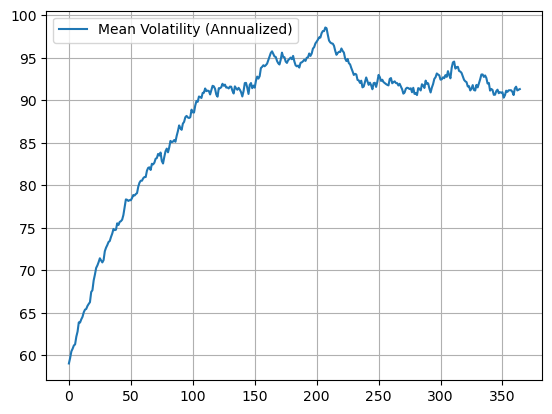

In [165]:
mean_volatility = np.mean(simulated_volatility_annualized.T, axis=1)

plt.plot(mean_volatility*100, label='Mean Volatility (Annualized)')
plt.legend()
plt.grid(True)
plt.show()

In [235]:
initial_price = btc_daily.iloc[-1]  # Adjust with daily or weekly
mu = np.array(mean)  # Drift (annualized mean return) 365 for daily, 52 for weekly
sigma = mean_volatility  # Volatility (annualized standard deviation)
time_horizon = 1  # 1 years
steps_per_year = 365  # 365 for daily, 52 for weekly
num_simulations = 1000  # Number of Monte Carlo simulations

price_paths_egarch = simulate_gbm(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations)

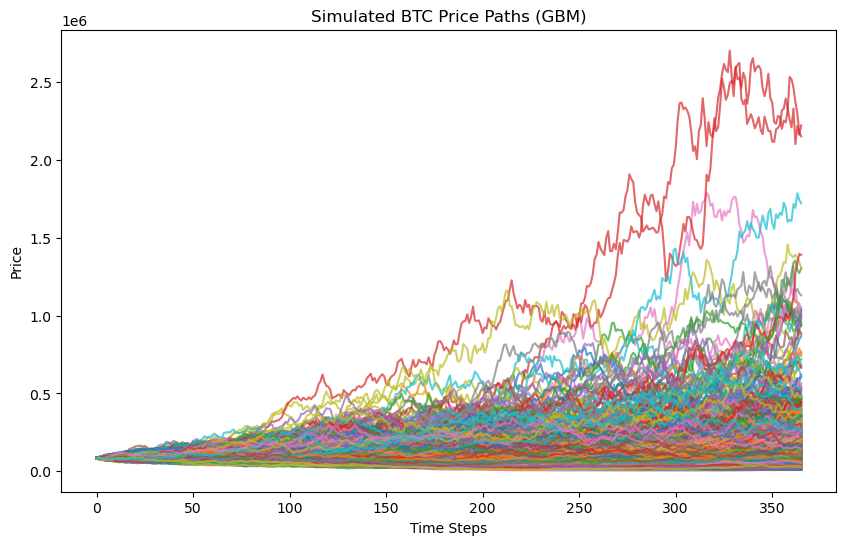

In [167]:
# Plot some simulated paths
plt.figure(figsize=(10, 6))
plt.plot(price_paths_egarch, alpha=0.7)
plt.title("Simulated BTC Price Paths (GBM)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()

#### CPPI

In [168]:
# Run CPPI strategy for all combinations
cppi_results_egarch = cppi_strategy(price_paths_egarch, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [169]:
# Select a (multiplier, floor) combination
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

# Get terminal prices and CPPI values
terminal_prices = price_paths_egarch[-1]  # Last row of price simulations
terminal_cppi = cppi_results_egarch[key]['Basket Values'][-1]  # Last row of CPPI values

#### OBPI

In [237]:
time_to_maturity = len(price_paths_egarch)/365  # adjust (52 for weekly, 365 for daily)

obpi_results_egarch = obpi_strategy(price_paths_egarch[:-1,:], 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, simulated_volatility_annualized[0,].T)

In [171]:
# Select a (multiplier, floor) combination
floor_frac_obpi = 1
key = (floor_frac_obpi)

# Get terminal prices and CPPI values
terminal_prices = price_paths_egarch[-1]  # Last row of price simulations
terminal_obpi = obpi_results_egarch[key]['Basket Values'][-1]  # Last row of obpi values

#### Buy & Hold

In [172]:
# Run the strategy
bnh_results_egarch = buy_and_hold_strategy(
    price_paths=price_paths_egarch,
    riskless_rate=0.04,
    initial_portfolio_value=100000,
    time_to_maturity=len(price_paths_egarch)/365
)

In [173]:
# Get terminal prices and CPPI values
terminal_prices = price_paths_egarch[-1]  # Last row of price simulations
terminal_bnh = bnh_results_egarch['Basket Values'][-1]  # Last row of CPPI values

#### Comparison

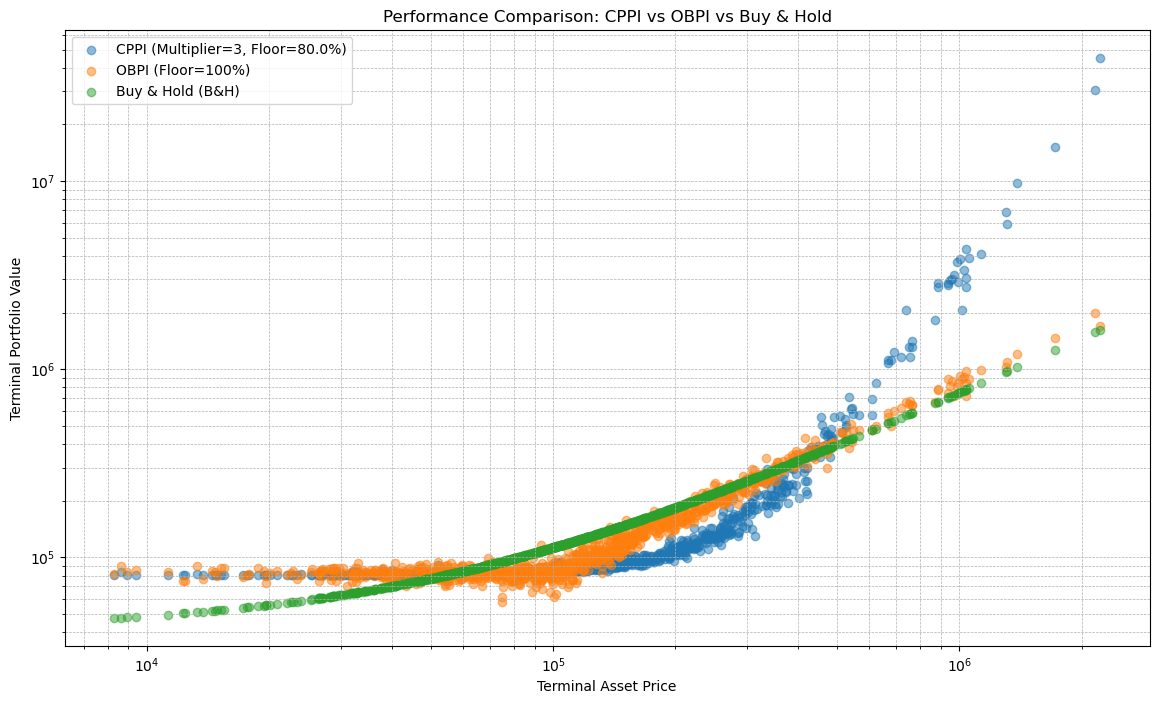

In [174]:
# Create a combined figure for CPPI, OBPI, and Buy & Hold
plt.figure(figsize=(14, 8))

# CPPI Outcomes (with multiplier and floor)
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# OBPI Outcomes (with floor)
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Floor={floor_frac_obpi*100}%)')

# Buy & Hold (B&H) Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='Buy & Hold (B&H)')

# Customize plot aesthetics
plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [276]:
benchmark_prices = price_paths_egarch

# CPPI Strategy Performance
cppi_strategy_results = cppi_results_egarch[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = annualized_turnover(cppi_strategy_results, 365)

# OBPI Strategy Performance
obpi_strategy_results = obpi_results_egarch[1]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices[:-1,:])
obpi_turnover = annualized_turnover(obpi_strategy_results, 365)

# Buy-and-Hold Strategy Performance
bnh_portfolio_values = np.array(bnh_results_egarch['Basket Values'])
bnh_metrics = performance(bnh_portfolio_values, benchmark_prices)
bnh_turnover = 0  # No turnover for B&H

# Display Results
def print_metrics(name, metrics, turnover):
    print(f"{name} Strategy Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    print(f"Annualized Turnover: {turnover:.2f}%\n")

print_metrics("CPPI", cppi_metrics, cppi_turnover)
print_metrics("OBPI", obpi_metrics, obpi_turnover)
print_metrics("Buy-and-Hold", bnh_metrics, bnh_turnover)

CPPI Strategy Metrics:
Annualized Return: 1.9530
Annualized Volatility: 0.6896
Sharpe Ratio: 0.7776
Sortino Ratio: 1.5797
Var 5: -0.0575
Es 5: -0.0822
Skewness: -0.1334
Kurtosis: 4.0371
Max Drawdown: -46.8159
Information Ratio: -0.3697
Annualized Turnover: 1534.01%

OBPI Strategy Metrics:
Annualized Return: 0.6166
Annualized Volatility: 0.5048
Sharpe Ratio: 0.6317
Sortino Ratio: 1.2929
Var 5: -0.0423
Es 5: -0.0572
Skewness: -0.0115
Kurtosis: 2.7921
Max Drawdown: -37.6815
Information Ratio: -1.0607
Annualized Turnover: 764.63%

Buy-and-Hold Strategy Metrics:
Annualized Return: 0.6893
Annualized Volatility: 0.5631
Sharpe Ratio: 0.9813
Sortino Ratio: 1.8719
Var 5: -0.0461
Es 5: -0.0582
Skewness: 0.1030
Kurtosis: 0.2751
Max Drawdown: -42.2570
Information Ratio: -0.2553
Annualized Turnover: 0.00%



## Merton Jump Diffusion

In [176]:
def simulate_merton_jump_diffusion(
    S0: float,               # Initial price
    mu: float,               # Annual drift
    sigma: float,            # Annual volatility (GBM part)
    lambd: float,            # Jump intensity (λ, jumps/year)
    mu_jump: float,          # Mean log-jump size (μ_J)
    sigma_jump: float,       # Jump size volatility (σ_J)
    T: float,                # Time horizon (years)
    steps: int,              # Number of time steps
    n_simulations: int,      # Number of paths
) -> np.ndarray:
    """
    Simulates price paths using Merton's Jump-Diffusion model.
    
    Returns:
        np.ndarray: Shape (steps + 1, n_simulations)
    """
    dt = T / steps  # Time step
    k = np.exp(mu_jump + 0.5 * sigma_jump**2) - 1  # Average jump size adjustment
    
    # Initialize price matrix
    S = np.zeros((steps + 1, n_simulations))
    S[0] = S0
    
    for t in range(1, steps + 1):
        # Poisson jumps (number of jumps in this step)
        m = np.random.poisson(lambd * dt, n_simulations)
        
        # GBM component
        Z = np.random.randn(n_simulations)
        gbm = (mu - lambd * k - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        
        # Jump component
        jump_sizes = np.zeros(n_simulations)
        for i in range(n_simulations):
            if m[i] > 0:
                # Sum of m[i] log-normal jumps
                jump_sizes[i] = np.sum(
                    mu_jump - 0.5 * sigma_jump**2 + sigma_jump * np.random.randn(m[i]))
        
        # Update price
        S[t] = S[t-1] * np.exp(gbm + jump_sizes)
    
    return S

In [239]:
# Parameters
params = {
    "S0": btc_daily.iloc[-1],              # Initial price
    "mu": float(mean.iloc[0]),             # 5% annual drift
    "sigma": float(volatility.iloc[0]),          # 20% annual volatility (GBM)
    "lambd": 0.25,           # ~1 jump every 2 years
    "mu_jump": -0.3,        # Average jump drops price by ~10% (μ_J)
    "sigma_jump": 0.2,     # Jump size volatility (σ_J)
    "T": 1,                 # 1 year
    "steps": 365,           # Daily steps
    "n_simulations": 1000,
}

# Simulate paths
price_paths_jumps = simulate_merton_jump_diffusion(**params)

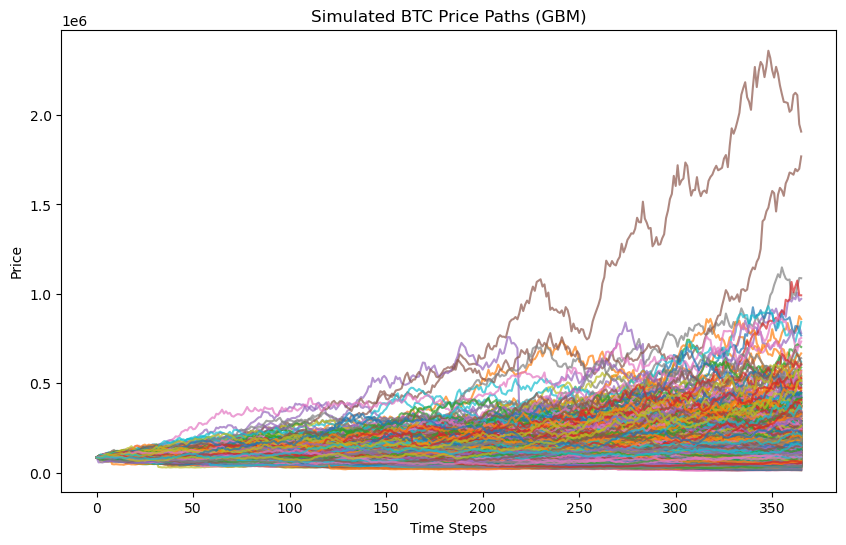

In [240]:
# Plot some simulated paths
plt.figure(figsize=(10, 6))
plt.plot(price_paths_jumps, alpha=0.7)
plt.title("Simulated BTC Price Paths (GBM)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()

#### CPPI

In [178]:
# Run CPPI strategy for all combinations
cppi_results_jumps = cppi_strategy(price_paths_jumps, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [179]:
# Select a (multiplier, floor) combination
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

# Get terminal prices and CPPI values
terminal_prices = price_paths_jumps[-1]  # Last row of price simulations
terminal_cppi = cppi_results_jumps[key]['Basket Values'][-1]  # Last row of CPPI values

#### OBPI

In [180]:
time_to_maturity = len(price_paths_jumps)/365  # adjust (52 for weekly, 365 for daily)

obpi_results_jumps = obpi_strategy(price_paths_jumps, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, float(volatility.iloc[0]))

In [181]:
# Select a (multiplier, floor) combination
floor_frac_obpi = 1
key = (floor_frac_obpi)

# Get terminal prices and CPPI values
terminal_prices = [-1]  # Last row of price simulations
terminal_obpi = obpi_results_jumps[key]['Basket Values'][-1]  # Last row of obpi values

#### Buy & Hold

In [182]:
# Run the strategy
bnh_results_jumps = buy_and_hold_strategy(
    price_paths=price_paths_jumps,
    riskless_rate=0.04,
    initial_portfolio_value=100000,
    time_to_maturity=len(price_paths_jumps)/365
)

In [183]:
# Get terminal prices and CPPI values
terminal_prices = price_paths_jumps[-1]  # Last row of price simulations
terminal_bnh = bnh_results_jumps['Basket Values'][-1]  # Last row of CPPI values

#### Comparison

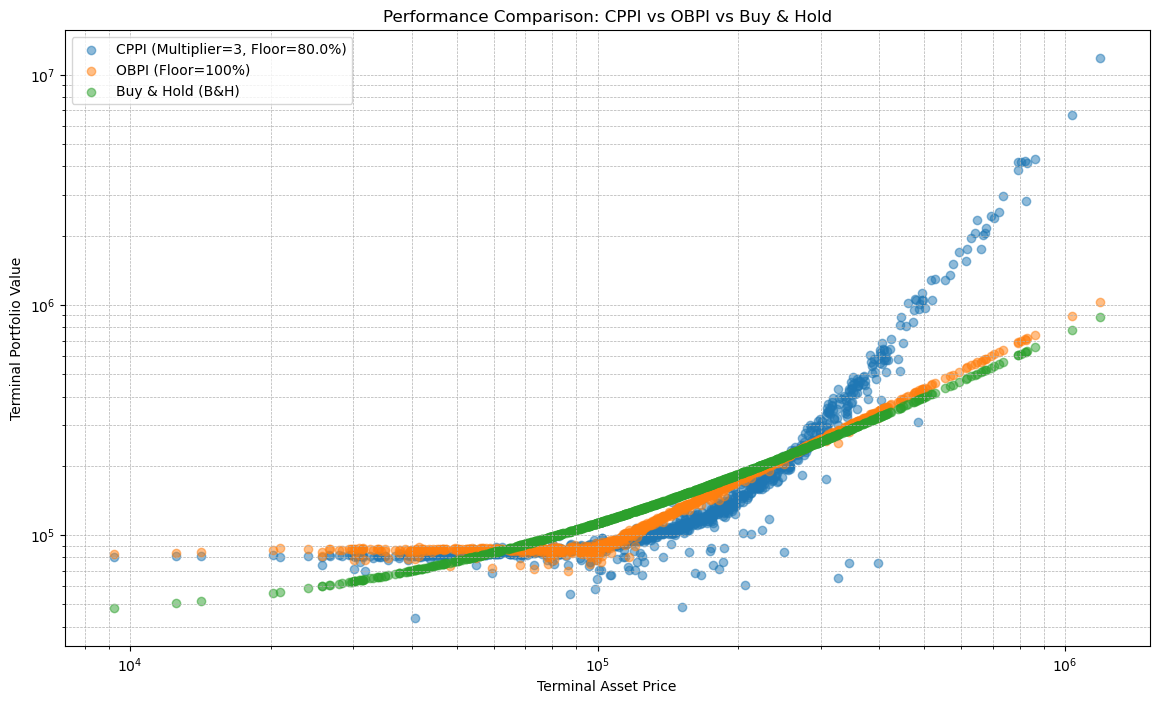

In [184]:
# Create a combined figure for CPPI, OBPI, and Buy & Hold
plt.figure(figsize=(14, 8))

# CPPI Outcomes (with multiplier and floor)
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# OBPI Outcomes (with floor)
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Floor={floor_frac_obpi*100}%)')

# Buy & Hold (B&H) Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='Buy & Hold (B&H)')

# Customize plot aesthetics
plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [318]:
benchmark_prices = price_paths_jumps

# CPPI Strategy Performance
cppi_strategy_results = cppi_results_jumps[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = annualized_turnover(cppi_strategy_results, 365)

# OBPI Strategy Performance
obpi_strategy_results = obpi_results_jumps[1]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices)
obpi_turnover = annualized_turnover(obpi_strategy_results, 365)

# Buy-and-Hold Strategy Performance
bnh_portfolio_values = np.array(bnh_results_jumps['Basket Values'])
bnh_metrics = performance(bnh_portfolio_values, benchmark_prices)
bnh_turnover = 0  # No turnover for B&H

# Display Results
def print_metrics(name, metrics, turnover):
    print(f"{name} Strategy Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    print(f"Annualized Turnover: {turnover:.2f}%\n")

print_metrics("CPPI", cppi_metrics, cppi_turnover)
print_metrics("OBPI", obpi_metrics, obpi_turnover)
print_metrics("Buy-and-Hold", bnh_metrics, bnh_turnover)

CPPI Strategy Metrics:
Annualized Return: 1.3859
Annualized Volatility: 0.6453
Sharpe Ratio: 0.9080
Sortino Ratio: 1.7649
Var 5: -0.0518
Es 5: -0.0742
Skewness: -0.8223
Kurtosis: 16.1559
Max Drawdown: -43.9270
Information Ratio: -0.3431
Annualized Turnover: 1391.81%

OBPI Strategy Metrics:
Annualized Return: 0.6410
Annualized Volatility: 0.4219
Sharpe Ratio: 0.9863
Sortino Ratio: 1.9055
Var 5: -0.0339
Es 5: -0.0468
Skewness: -0.4717
Kurtosis: 10.5242
Max Drawdown: -30.8480
Information Ratio: -0.4217
Annualized Turnover: 614.06%

Buy-and-Hold Strategy Metrics:
Annualized Return: 0.6895
Annualized Volatility: 0.4588
Sharpe Ratio: 1.3203
Sortino Ratio: 2.4642
Var 5: -0.0365
Es 5: -0.0475
Skewness: -0.2514
Kurtosis: 6.2672
Max Drawdown: -33.4325
Information Ratio: -0.3106
Annualized Turnover: 0.00%



## Heston Model

In [186]:
def identity(x):
    return x

def heston_simulate(rate: float, sharpe_ratio: float, initial_price: float,
                    kappa: float, lt_var: float, vol_var: float, initial_var: float, rho: float,
                    n_paths: int, time_step: float, n_periods: int,
                    rng: np.random.Generator,
                    transform=identity):
    """
    Simulate paths for price and volatility under the Heston model.
    Note that this function has a side effect because it changes the state of the random number generator.
    """
    
    logS = np.empty((n_periods + 1, n_paths))  # Pre-allocate log prices
    V = np.empty((n_periods + 1, n_paths))  # Pre-allocate variances
    
    logS[0, :] = np.log(initial_price)  # Initial log price
    V[0, :] = initial_var  # Initial variance
    
    loading2 = np.sqrt(1 - rho**2)
    
    for i in range(1, n_periods + 1):
        std_innov1 = rng.standard_normal(n_paths)  # Standard normal innovations
        std_innov2 = rng.standard_normal(n_paths)
        
        sigma = np.sqrt(np.maximum(V[i - 1, :], 0))  # Ensure non-negative volatility
        
        logS[i, :] = logS[i - 1, :] + (rate + sharpe_ratio * sigma - 0.5 * V[i - 1, :]) * time_step \
            + sigma * np.sqrt(time_step) * std_innov1
            
        V[i, :] = V[i - 1, :] + kappa * (lt_var - V[i - 1, :]) * time_step \
            + vol_var * sigma * np.sqrt(time_step) * (rho * std_innov1 + loading2 * std_innov2)
            
        V[i, :] = transform(np.maximum(V[i, :], 0))  # Ensure variance is non-negative
    
    S = np.exp(logS)  # Convert log prices back to prices
    
    return {'price': S, 'volatility': np.sqrt(V)}

In [322]:
rate = mean.iloc[0]
initial_price = btc_daily.iloc[-1]
sharpe_ratio = sharpe_ratio
kappa = 2
vol_var = .7
lt_var = volatility.iloc[0]**2
initial_var = 0.5**2
rho = -0.6
n_paths = 1000
time_step = 1 / 365
n_periods = 365

rng = np.random.default_rng(seed=123)

SV = heston_simulate(rate, sharpe_ratio, initial_price,
                     kappa, lt_var, vol_var, initial_var, rho,
                     n_paths, time_step, n_periods,
                     rng)

In [323]:
price_paths_heston = SV['price']
vol_paths_heston = SV['volatility']

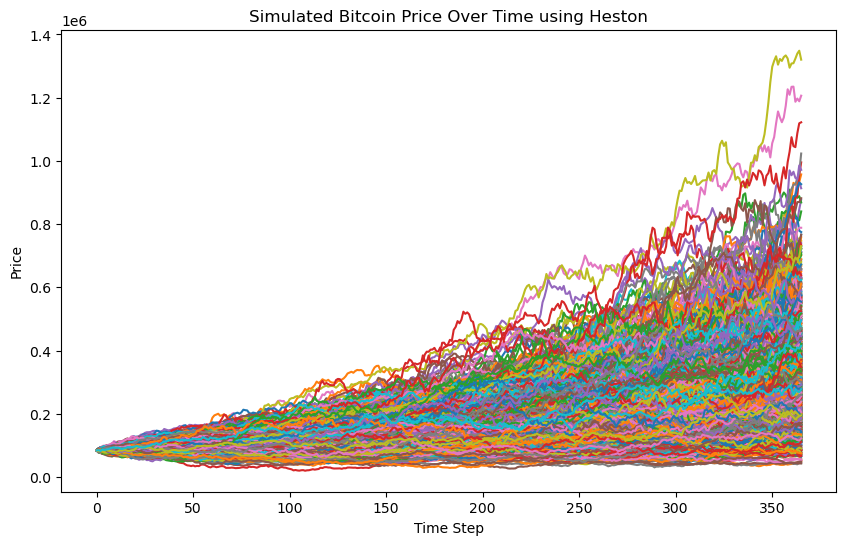

In [324]:
plt.figure(figsize=(10, 6))
plt.plot(price_paths_heston)
plt.title("Simulated Bitcoin Price Over Time using Heston")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.show()

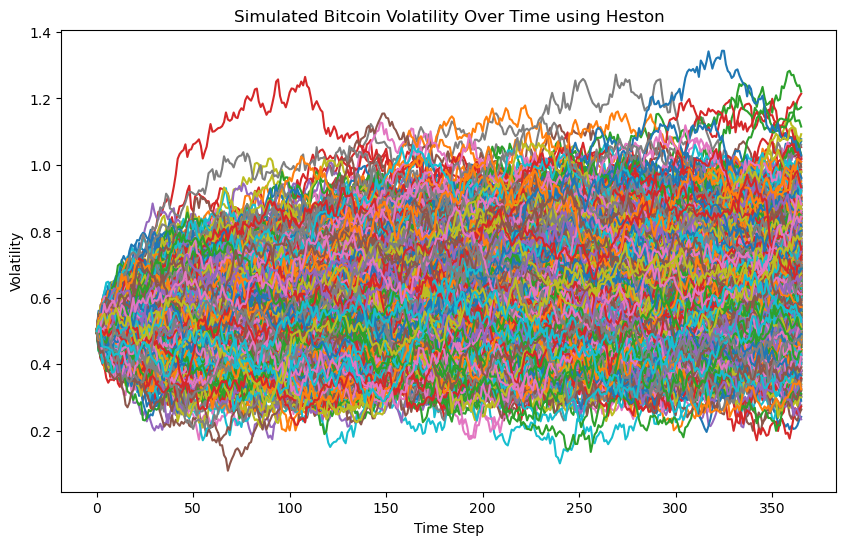

In [325]:
plt.figure(figsize=(10, 6))
plt.plot(vol_paths_heston)
plt.title("Simulated Bitcoin Volatility Over Time using Heston")
plt.xlabel("Time Step")
plt.ylabel("Volatility")
plt.show()

#### CPPI

In [326]:
# Run CPPI strategy for all combinations
cppi_results_heston = cppi_strategy(price_paths_heston, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [327]:
# Select a (multiplier, floor) combination
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

# Get terminal prices and CPPI values
terminal_prices = price_paths_heston[-1]  # Last row of price simulations
terminal_cppi = cppi_results_heston[key]['Basket Values'][-1]  # Last row of CPPI values

#### OBPI

In [328]:
time_to_maturity = len(price_paths_heston)/365  # adjust (52 for weekly, 365 for daily)

obpi_results_heston = obpi_strategy(price_paths_heston, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, float(volatility.iloc[0]))

In [329]:
# Select a (multiplier, floor) combination
floor_frac_obpi = 1
key = (floor_frac_obpi)

# Get terminal prices and CPPI values
terminal_prices = [-1]  # Last row of price simulations
terminal_obpi = obpi_results_heston[key]['Basket Values'][-1]  # Last row of obpi values

#### Buy & Hold

In [330]:
# Run the strategy
bnh_results_heston = buy_and_hold_strategy(
    price_paths=price_paths_heston,
    riskless_rate=0.04,
    initial_portfolio_value=100000,
    time_to_maturity=len(price_paths_heston)/365
)

In [331]:
# Get terminal prices and CPPI values
terminal_prices = price_paths_heston[-1]  # Last row of price simulations
terminal_bnh = bnh_results_heston['Basket Values'][-1]  # Last row of CPPI values

#### Comparison

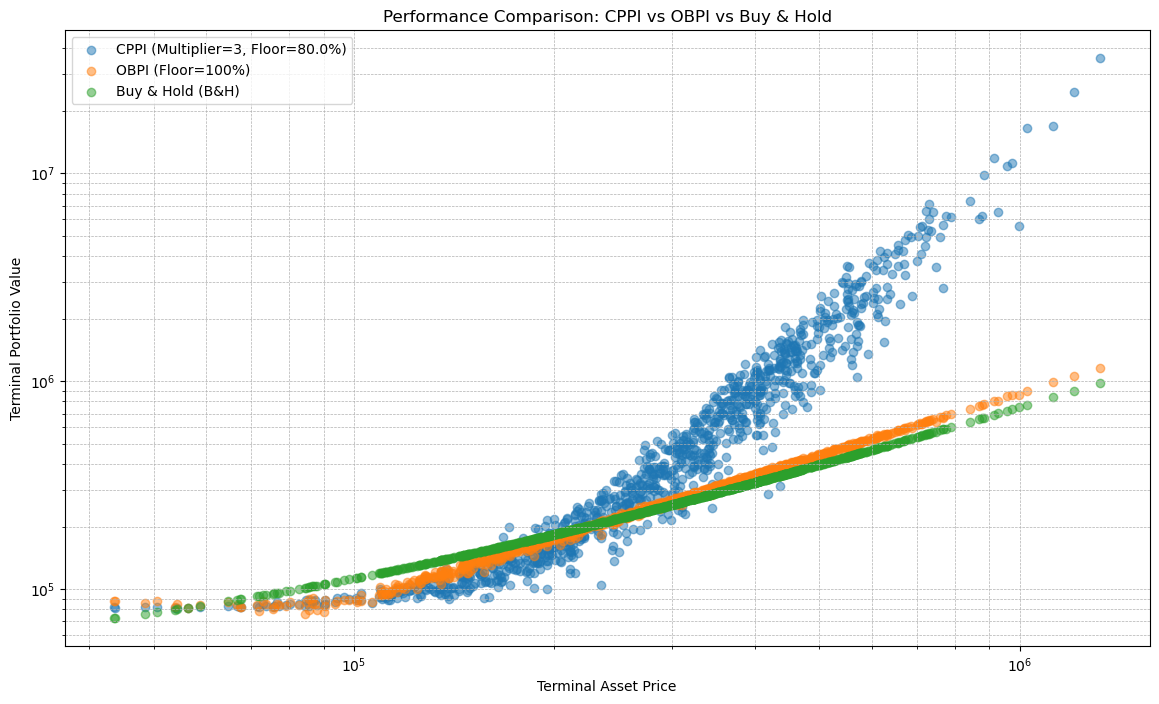

In [332]:
# Create a combined figure for CPPI, OBPI, and Buy & Hold
plt.figure(figsize=(14, 8))

# CPPI Outcomes (with multiplier and floor)
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# OBPI Outcomes (with floor)
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Floor={floor_frac_obpi*100}%)')

# Buy & Hold (B&H) Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='Buy & Hold (B&H)')

# Customize plot aesthetics
plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [333]:
benchmark_prices = price_paths_heston

# CPPI Strategy Performance
cppi_strategy_results = cppi_results_heston[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = annualized_turnover(cppi_strategy_results, 365)

# OBPI Strategy Performance
obpi_strategy_results = obpi_results_heston[1]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices)
obpi_turnover = annualized_turnover(obpi_strategy_results, 365)

# Buy-and-Hold Strategy Performance
bnh_portfolio_values = np.array(bnh_results_heston['Basket Values'])
bnh_metrics = performance(bnh_portfolio_values, benchmark_prices)
bnh_turnover = 0  # No turnover for B&H

# Display Results
def print_metrics(name, metrics, turnover):
    print(f"{name} Strategy Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    print(f"Annualized Turnover: {turnover:.2f}%\n")

print_metrics("CPPI", cppi_metrics, cppi_turnover)
print_metrics("OBPI", obpi_metrics, obpi_turnover)
print_metrics("Buy-and-Hold", bnh_metrics, bnh_turnover)

CPPI Strategy Metrics:
Annualized Return: 8.2466
Annualized Volatility: 0.8872
Sharpe Ratio: 7.7240
Sortino Ratio: 15.0962
Var 5: -0.0696
Es 5: -0.0962
Skewness: 0.1354
Kurtosis: 4.8578
Max Drawdown: -46.9329
Information Ratio: 0.6378
Annualized Turnover: 1472.46%

OBPI Strategy Metrics:
Annualized Return: 1.8635
Annualized Volatility: 0.4668
Sharpe Ratio: 3.9714
Sortino Ratio: 7.6679
Var 5: -0.0364
Es 5: -0.0488
Skewness: 0.1703
Kurtosis: 4.3101
Max Drawdown: -26.9748
Information Ratio: -2.0885
Annualized Turnover: 425.13%

Buy-and-Hold Strategy Metrics:
Annualized Return: 1.7187
Annualized Volatility: 0.4340
Sharpe Ratio: 4.0447
Sortino Ratio: 7.8240
Var 5: -0.0336
Es 5: -0.0435
Skewness: 0.1296
Kurtosis: 3.4802
Max Drawdown: -24.8926
Information Ratio: -2.4331
Annualized Turnover: 0.00%

